# **IBM APPLIED DATA SCIENCE CAPSTONE PROJECT**

# The Battle of Neighborhood -- Week 2

# Finding the Best Neighborhoods to Open a Few  African Restaurants in Toronto

## 1. Introduction and Business Problem

####  Introduction

Toronto is the provincial capital of Ontario and the most populous city in Canada, with a population of 2,7M as of 2016. Current to 2016, the Toronto census metropolitan area (CMA), of which the majority is within the Greater Toronto Area (GTA), held a population of 5.9 million, making it Canada's most populous CMA and the fourth most populous city in North America.<br>
Experts predict that by 2035, the city’s population will have gained another 1 million residents. 

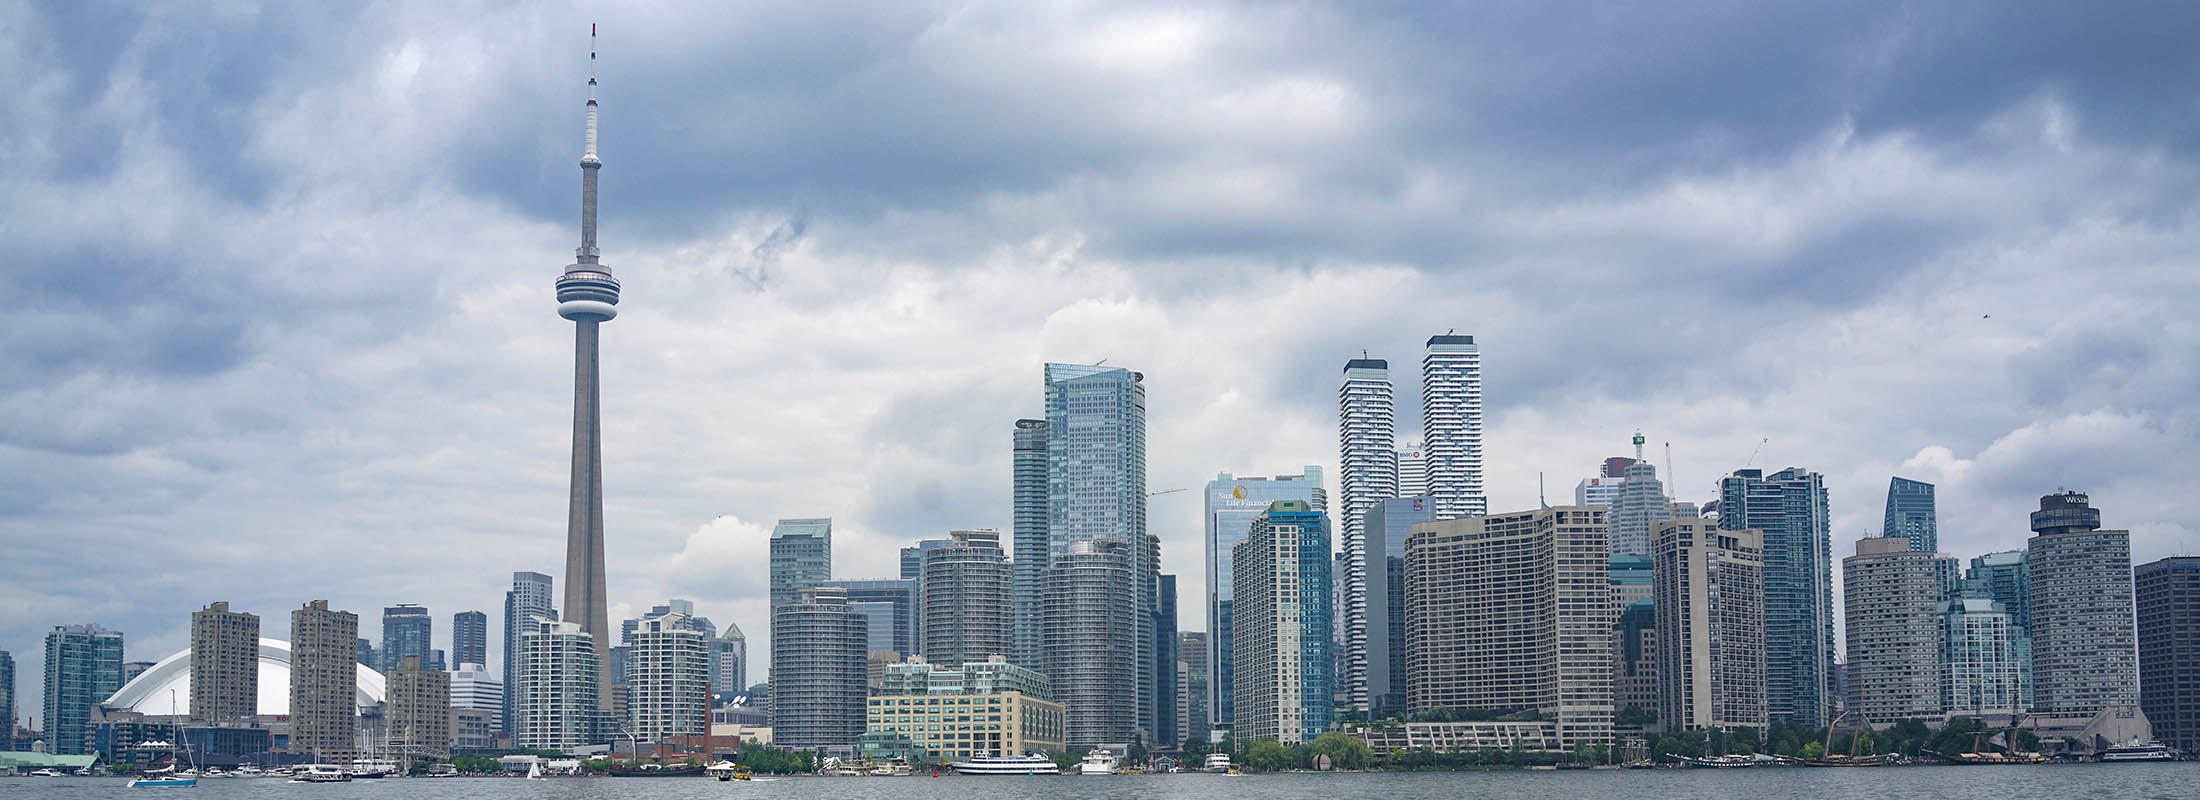

Toronto is an international centre of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world. Nearly half the population of Toronto is foreign-born, with 50% of the population identifies as white, while the rest identify as East Indian, South Asian, Black, Southeast Asian, Latin American, West Asian, and Arab. While the majority of Torontonians speak English as their primary language, over 160 languages are spoken in the city.<br>
Reflecting this diverse population, Toronto has many ethnic neighborhoods where immigrant populations find comfort and familiarity, this includes neighborhoods like Little India, Greektown, Little Italy, Chinatown, Little Portugal, and Little Jamaica. Toronto is a prominent center for music, theatre, motion picture production, and television production, and is home to the headquarters of Canada's major national broadcast networks and media outlets and varied cultural institutions, which include numerous museums and galleries, festivals and public events, entertainment districts, national historic sites, and sports activities that attract over 43 million tourists each year.

#### Business Problem

Being the fastest growing city in North America, Toronto is home to more than 140 languages. According to Statistics Canada, while English is the predominant language in Toronto, other languages such as Cantonese, Mandarin, Tagalog, Italian, Spanish, Farsi, Russian, Korean, Tamil, Urdu, Polish, Somali, Arabic, Panjabi, Vietnamese and more each have tens of thousands of speakers. With this diverse culture, naturally comes diverse food and tastes.Therefore,a consortium of African restaurants having the goal to build up an African restaurant chain around the is exploring opportunities to open a few restaurants in Toronto, and need some suggestions.

## 2. Data Sources

#### Toronto Data
Used beautifulSoup to scrape a data frame of Toronto from the  csv file from the Wikipedia page below. It allows us to obtain the information about the boroughs and neighborhoods along with the postal codes.<br>
Data source : https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

#### Geocoder
Used to map the geographical coordinates of the neighborhoods through the postal code.<br>
Link of the csv file: http://cocl.us/Geospatial_data

#### Foursquare API
Foursquare API is used to retrieve data from the Foursquare database, and explore venues and types of restaurant in Toronto Neighborhoods.<br>
Data source: https://developer.foursquare.com/docs/places-api/

## 3. Approach

Toronto is city with diverse culture, restaurants. There are many types or international restaurants in Toronto, such as Chinese, Indian, and French. The approach is to find out first whether there is an African restaurant in Toronto. If yes, determine the corresponding neighborhoods and the stories behind them, which might be used to open similar restaurant in other neighborhoods. Those neighborhoods are identified and considered for the selection in case they are not in the list of the top Neighborhoods by venues (international restaurants). The top neighborhoods with the most international restaurants or multicultural communities where people may try diverse types of cuisines associated with the top communities having the highest percentage of black population will help determine the rights cluster for opening the few restaurants in Toronto.

## 4. Methodology

1.	Scraped data and build a data frame of Toronto contains its Boroughs’ list, Neighborhoods along with their latitude and longitude. 
2.	Use the Geocoder to map the geographical coordinates of the neighborhoods through the postal code
3.	Use Foursquare API to explore the neighborhoods in Toronto by venues while focusing only on restaurants
4.	Check whether there is an African restaurant. If yes check out the corresponding neighborhood and discard it from the list if it's not on the list of the top neighborhoods
5.	List and plot the 10 top international restaurants by frequency in Toronto
6.	List the top international restaurants for the selected top neighborhoods
7.	Cluster the top neighborhoods based on the frequency of international restaurants by using k-means
8.	Cluster visualization
9.	Clusters Exploring
10.	Results and selection of the ideal location to open a few African restaurants
11. Discussions
11.	Conclusion

### First of all, let's import all necessary python library

In [1]:
#install Folium, geopy, and beautifulsoup4
!conda install -c conda-forge folium --yes
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge beautifulsoup4 --yes
print('The required libraries installed')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    folium-0.11.0              |             py_0          61 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    branca:          0.4.1-py_0        conda-forge
    folium:          

### Let's import the required libraries

In [3]:
import pandas as pd
import numpy as np
import folium
import seaborn as sns
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 
import requests 
import json 
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
import os
%matplotlib inline

### A. Create Toronto Dataframe

#### 1. Use Beautifulsoup to Scrap the Web

In [4]:
#create an object with the data from the Wikipedia page
website_url = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(website_url)

In [5]:
#find the table in the website
myTable = soup.find('table',{'class':'wikitable sortable'})

In [6]:
#extract the table data of Wikipedia
wiki_data = [] 
for row in myTable.find_all("tr"):
    cols = row.find_all("td")
    cols = [ele.text.strip() for ele in cols]
    wiki_data.append(cols)

#### 2. Create the Dataframe

In [7]:
#create a panda dataframe
import pandas as pd
df = pd.DataFrame(wiki_data)

#The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
df = df.rename(columns={0:"PostalCode",1:"Borough",2:"Neighborhood"})

#Only process the cells that have an assigned borough:
#1)drop the first row
df2 = df.copy()
df2 = df.drop([0])

#2)drop cells with a borough that is Not assigned
df2 = df2.drop(df2[df2['Borough']=='Not assigned'].index)
df2 = df2.reset_index(drop=True)

#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
df3 = df2.copy()
df3['Neighborhood'] = df3.apply(
    lambda row: row['Borough'] if row['Neighborhood'] == 'Not assigned' else row['Neighborhood'],
    axis=1
)

#if there is more than one neighborhood in one postal code area, combine those rows and separate the neighborhoods with a comma (group the dataframe by postcode and borough,and then join the neighborhoods)
df4 = df3.copy()
df4 = (df4.groupby(['PostalCode','Borough'])['Neighborhood']
       .apply(lambda x: ','.join(set(x.dropna())))
       .reset_index())

df4 = pd.DataFrame(df4)

In [9]:
df4.head()

PostalCode      Borough                            Neighborhood
0        M1B  Scarborough                          Malvern, Rouge
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek
2        M1E  Scarborough       Guildwood, Morningside, West Hill
3        M1G  Scarborough                                  Woburn
4        M1H  Scarborough                               Cedarbrae

In [8]:
df4.shape

(103, 3)

### B. Create the Dataframe With Longitude and Latitude

#### 1. Get the latitude and the longitude coordinates of each neighborhood from the CSV file

In [9]:
# read csv file from the address
df_Geo_Coord = pd.read_csv('http://cocl.us/Geospatial_data', sep = ',') 
# examine the shape of original input data

df_Geo_Coord.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [10]:
#Combibe it with the previous data frame
df_toronto= pd.concat([df4, df_Geo_Coord], axis=1)
df_toronto= df_toronto.drop(['Postal Code'], axis =1 )
df_toronto.head()

PostalCode      Borough                            Neighborhood   Latitude  \
0        M1B  Scarborough                          Malvern, Rouge  43.806686   
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [11]:
df_toronto.shape

(103, 5)

### C. Get the Coordinates from the GeoCoder and Plot The Neighborhoods on Toronto Map

#### 1. Use geopy library to get the latitude and longitude values of Toronto

In [12]:
# getting the coordinates of Toronto
address = 'Toronto, Ontario Canada'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto Canada are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of Toronto Canada are 43.6534817, -79.3839347.


#### 2. Use Folium to create a map for Toronto neighborhoods

In [13]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#87cefa',
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto)
map_toronto

### D. Explore the Neighborhoods in Toronto Based on Top Venues in the Boroughs

#### 1. Explore the neighborhoods in Toronto using Foursquare API

In [1]:
# The code was removed by Watson Studio for sharing.

CLIENT_ID: U5MOVPKK0WOD4YRU3A52BQ3HKHE0GQI2J3DOWFWALQ1T1FM3
CLIENT_SECRET: RIK0ZZ4P3JNVNWWYDMLCARZ0QPG4ITSEV5UVH1F0QQGIKVKT


In [15]:
#let's define a function that help provide the nearby venues 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([( name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [16]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'], latitudes=df_toronto['Latitude'],longitudes=df_toronto['Longitude'])

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

#### 2. Focus on the restaurants only 

In [17]:
# Create a data frame of restaurant venues only
toronto_venues_only_restaurant = toronto_venues[toronto_venues['Venue Category']\
                                                          .str.contains('Restaurant')].reset_index(drop=True)
toronto_venues_only_restaurant.index = np.arange(1, len(toronto_venues_only_restaurant)+1)
print ("Shape of the data frame with Venue Category only Restaurant: ", toronto_venues_only_restaurant.shape)
toronto_venues_only_restaurant.head(10)

Shape of the data frame with Venue Category only Restaurant:  (291, 7)


Neighborhood  Neighborhood Latitude  \
1                                      Malvern, Rouge              43.806686   
2                   Guildwood, Morningside, West Hill              43.763573   
3                                              Woburn              43.770992   
4                                              Woburn              43.770992   
5                                           Cedarbrae              43.773136   
6                                           Cedarbrae              43.773136   
7                                           Cedarbrae              43.773136   
8         Kennedy Park, Ionview, East Birchmount Park              43.727929   
9     Cliffside, Cliffcrest, Scarborough Village West              43.716316   
10  Dorset Park, Wexford Heights, Scarborough Town...              43.757410   

    Neighborhood Longitude                     Venue  Venue Latitude  \
1               -79.194353                   Wendy’s       43.807448   
2               -79.188711          Big Bite Burrito       43.766299   
3               -79.216917        Korean Grill House       43.770812   
4               -79.216917   Al-Hamd Biryani & Pizza       43.767585   
5               -79.239476       Federick Restaurant       43.774697   
6               -79.239476  Drupati's Roti & Doubles       43.775222   
7               -79.239476               Thai One On       43.774468   
8               -79.262029                Hakka No.1       43.727688   
9               -79.239476            Vincent's Spot       43.717002   
10              -79.273304                   Kairali       43.754915   

    Venue Longitude        Venue Category  
1        -79.199056  Fast Food Restaurant  
2        -79.190720    Mexican Restaurant  
3        -79.214502     Korean Restaurant  
4        -79.219570     Indian Restaurant  
5        -79.241142      Hakka Restaurant  
6        -79.241678  Caribbean Restaurant  
7        -79.241268       Thai Restaurant  
8        -79.266057    Chinese Restaurant  
9        -79.242353   American Restaurant  
10       -79.276945     Indian Restaurant

#### 3. Find out the number and names of unique categories of international restaurant 

In [18]:
print('This is the list of uniques international restaurant types in Toronto {}.'.format(list(toronto_venues_only_restaurant['Venue Category'].unique()))) 
print('There are {} unique types or restaurant.'.format(len(toronto_venues_only_restaurant['Venue Category'].unique())))

This is the list of uniques international restaurant types in Toronto ['Fast Food Restaurant', 'Mexican Restaurant', 'Korean Restaurant', 'Indian Restaurant', 'Hakka Restaurant', 'Caribbean Restaurant', 'Thai Restaurant', 'Chinese Restaurant', 'American Restaurant', 'Vietnamese Restaurant', 'Middle Eastern Restaurant', 'Latin American Restaurant', 'Italian Restaurant', 'Mediterranean Restaurant', 'Restaurant', 'Japanese Restaurant', 'Ramen Restaurant', 'Indonesian Restaurant', 'Sushi Restaurant', 'Asian Restaurant', 'Dim Sum Restaurant', 'Portuguese Restaurant', 'Greek Restaurant', 'Seafood Restaurant', 'Comfort Food Restaurant', 'Taiwanese Restaurant', 'Theme Restaurant', 'Ethiopian Restaurant', 'French Restaurant', 'New American Restaurant', 'Vegetarian / Vegan Restaurant', 'Modern European Restaurant', 'Colombian Restaurant', 'Gluten-free Restaurant', 'Belgian Restaurant', 'Cuban Restaurant', 'Malay Restaurant', 'Cajun / Creole Restaurant', 'Eastern European Restaurant', 'Falafel Re

#### 4. Classify the uniques number of internationals by frequency in the neighborhoods

In [19]:
# classification of Toronto restaurant list by frequency
toronto_venues_only_restaurant_fl=toronto_venues_only_restaurant['Venue Category'].value_counts().to_frame(name='frequency')
toronto_venues_only_restaurant_fl=toronto_venues_only_restaurant_fl.reset_index()

toronto_venues_only_restaurant_fl.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)
toronto_venues_only_restaurant_fl

Venue Category  Frequency
0                      Restaurant         41
1              Italian Restaurant         26
2             Japanese Restaurant         19
3            Fast Food Restaurant         18
4                Sushi Restaurant         17
5             American Restaurant         12
6              Chinese Restaurant         12
7                 Thai Restaurant         12
8       Middle Eastern Restaurant         12
9              Seafood Restaurant         11
10              Indian Restaurant         11
11               Greek Restaurant         11
12  Vegetarian / Vegan Restaurant         11
13             Mexican Restaurant         10
14          Vietnamese Restaurant          8
15               Asian Restaurant          7
16        Comfort Food Restaurant          6
17              French Restaurant          6
18               Ramen Restaurant          6
19           Caribbean Restaurant          6
20        New American Restaurant          3
21      Latin American Restaurant          3
22              Korean Restaurant          2
23               Cuban Restaurant          2
24          Portuguese Restaurant          2
25         Gluten-free Restaurant          2
26       Mediterranean Restaurant          2
27           Ethiopian Restaurant          1
28               Hakka Restaurant          1
29           Taiwanese Restaurant          1
30           Colombian Restaurant          1
31          Indonesian Restaurant          1
32             Belgian Restaurant          1
33     Modern European Restaurant          1
34             Dim Sum Restaurant          1
35             Falafel Restaurant          1
36    Eastern European Restaurant          1
37               Malay Restaurant          1
38               Theme Restaurant          1
39      Cajun / Creole Restaurant          1

#### 4. Drop all raws corresponding to "Restaurant" since the type is not specified
#### We can also notic that there is also an Ethiopian Restaurant in the List at Raw 31

In [20]:
#let's focus on the international restaurant by dropping restaurant from the list
toronto_venues_only_restaurant_int=toronto_venues_only_restaurant[toronto_venues_only_restaurant['Venue Category']!=('Restaurant')].reset_index(drop=True)

toronto_venues_only_restaurant_int.index = np.arange(1, len(toronto_venues_only_restaurant_int)+1)
print ("Shape of the Data-Frame with Venue Category only International Restaurant: ", toronto_venues_only_restaurant_int.shape)
toronto_venues_only_restaurant_int.head(10)

Shape of the Data-Frame with Venue Category only International Restaurant:  (250, 7)


Neighborhood  Neighborhood Latitude  \
1                                      Malvern, Rouge              43.806686   
2                   Guildwood, Morningside, West Hill              43.763573   
3                                              Woburn              43.770992   
4                                              Woburn              43.770992   
5                                           Cedarbrae              43.773136   
6                                           Cedarbrae              43.773136   
7                                           Cedarbrae              43.773136   
8         Kennedy Park, Ionview, East Birchmount Park              43.727929   
9     Cliffside, Cliffcrest, Scarborough Village West              43.716316   
10  Dorset Park, Wexford Heights, Scarborough Town...              43.757410   

    Neighborhood Longitude                     Venue  Venue Latitude  \
1               -79.194353                   Wendy’s       43.807448   
2               -79.188711          Big Bite Burrito       43.766299   
3               -79.216917        Korean Grill House       43.770812   
4               -79.216917   Al-Hamd Biryani & Pizza       43.767585   
5               -79.239476       Federick Restaurant       43.774697   
6               -79.239476  Drupati's Roti & Doubles       43.775222   
7               -79.239476               Thai One On       43.774468   
8               -79.262029                Hakka No.1       43.727688   
9               -79.239476            Vincent's Spot       43.717002   
10              -79.273304                   Kairali       43.754915   

    Venue Longitude        Venue Category  
1        -79.199056  Fast Food Restaurant  
2        -79.190720    Mexican Restaurant  
3        -79.214502     Korean Restaurant  
4        -79.219570     Indian Restaurant  
5        -79.241142      Hakka Restaurant  
6        -79.241678  Caribbean Restaurant  
7        -79.241268       Thai Restaurant  
8        -79.266057    Chinese Restaurant  
9        -79.242353   American Restaurant  
10       -79.276945     Indian Restaurant

#### 5. Lets's find out the neighborhoods cooresponding to the "Ethiopian Restaurant" 

In [21]:
toronto_venues_only_restaurant_ER=toronto_venues_only_restaurant[toronto_venues_only_restaurant['Venue Category'].str.startswith ('Ethiopian')].reset_index(drop=True)
toronto_venues_only_restaurant_ER

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Church and Wellesley               43.66586               -79.38316   

             Venue  Venue Latitude  Venue Longitude        Venue Category  
0  Ethiopian House       43.666599       -79.385669  Ethiopian Restaurant

#### 6. Is it "Church and Wellesly" among the top neighborhoods by venues categories?

In [22]:
toronto_venues_only_restaurant_int.groupby('Neighborhood').count().sort_values(['Venue Category'], ascending=False)

Neighborhood Latitude  \
Neighborhood                                                                
Little Portugal, Trinity                                               13   
The Danforth West, Riverdale                                           11   
Kensington Market, Chinatown, Grange Park                               9   
Willowdale, Willowdale East                                             9   
Central Bay Street                                                      9   
Davisville                                                              8   
Bedford Park, Lawrence Manor East                                       8   
University of Toronto, Harbord                                          8   
Richmond, Adelaide, King                                                8   
Runnymede, Swansea                                                      8   
Don Mills                                                               8   
High Park, The Junction South                                           7   
Stn A PO Boxes                                                          7   
St. James Town                                                          7   
St. James Town, Cabbagetown                                             7   
Studio District                                                         7   
Berczy Park                                                             6   
Commerce Court, Victoria Hotel                                          5   
Church and Wellesley                                                    5   
First Canadian Place, Underground city                                  5   
Garden District, Ryerson                                                5   
Steeles West, L'Amoreaux West                                           4   
India Bazaar, The Beaches West                                          4   
Queen's Park, Ontario Provincial Government                             4   
Harbourfront East, Union Station, Toronto Islands                       4   
North Toronto West,  Lawrence Park                                      4   
Dorset Park, Wexford Heights, Scarborough Town ...                      4   
Thorncliffe Park                                                        4   
Clarks Corners, Tam O'Shanter, Sullivan                                 4   
Glencairn                                                               3   
...                                                                   ...   
Toronto Dominion Centre, Design Exchange                                3   
Cedarbrae                                                               3   
Canada Post Gateway Processing Centre                                   3   
New Toronto, Mimico South, Humber Bay Shores                            3   
The Annex, North Midtown, Yorkville                                     3   
Westmount                                                               2   
Woburn                                                                  2   
Northwood Park, York University                                         2   
Bayview Village                                                         2   
Bathurst Manor, Wilson Heights, Downsview North                         2   
Dufferin, Dovercourt Village                                            2   
Forest Hill North & West, Forest Hill Road Park                         1   
Wexford, Maryvale                                                       1   
Brockton, Parkdale Village, Exhibition Place                            1   
Victoria Village                                                        1   
Business reply mail Processing Centre, South Ce...                      1   
Christie                                                                1   
Cliffside, Cliffcrest, Scarborough Village West                         1   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        1   
Guildwood, Morningside, West Hill               

##### "Church and Wellesley" is among the top 25 neighboorhoods with the most number of international restaurants

#### 7. Let's create the final data frame of the neighborhood with international restaurants and plot the top 10 restaurants by frequency

In [23]:
toronto_venues_only_restaurant_int_final=toronto_venues_only_restaurant_int

toronto_venues_only_restaurant_int_final.index = np.arange(1, len(toronto_venues_only_restaurant_int_final)+1)
print ("Shape of the Data-Frame with Venue Category only International Restaurant: ", toronto_venues_only_restaurant_int_final.shape)
toronto_venues_only_restaurant_int_final.head(10)

Shape of the Data-Frame with Venue Category only International Restaurant:  (250, 7)


Neighborhood  Neighborhood Latitude  \
1                                      Malvern, Rouge              43.806686   
2                   Guildwood, Morningside, West Hill              43.763573   
3                                              Woburn              43.770992   
4                                              Woburn              43.770992   
5                                           Cedarbrae              43.773136   
6                                           Cedarbrae              43.773136   
7                                           Cedarbrae              43.773136   
8         Kennedy Park, Ionview, East Birchmount Park              43.727929   
9     Cliffside, Cliffcrest, Scarborough Village West              43.716316   
10  Dorset Park, Wexford Heights, Scarborough Town...              43.757410   

    Neighborhood Longitude                     Venue  Venue Latitude  \
1               -79.194353                   Wendy’s       43.807448   
2               -79.188711          Big Bite Burrito       43.766299   
3               -79.216917        Korean Grill House       43.770812   
4               -79.216917   Al-Hamd Biryani & Pizza       43.767585   
5               -79.239476       Federick Restaurant       43.774697   
6               -79.239476  Drupati's Roti & Doubles       43.775222   
7               -79.239476               Thai One On       43.774468   
8               -79.262029                Hakka No.1       43.727688   
9               -79.239476            Vincent's Spot       43.717002   
10              -79.273304                   Kairali       43.754915   

    Venue Longitude        Venue Category  
1        -79.199056  Fast Food Restaurant  
2        -79.190720    Mexican Restaurant  
3        -79.214502     Korean Restaurant  
4        -79.219570     Indian Restaurant  
5        -79.241142      Hakka Restaurant  
6        -79.241678  Caribbean Restaurant  
7        -79.241268       Thai Restaurant  
8        -79.266057    Chinese Restaurant  
9        -79.242353   American Restaurant  
10       -79.276945     Indian Restaurant

##### Plot the top 15 international restaurant by frequency and plot it

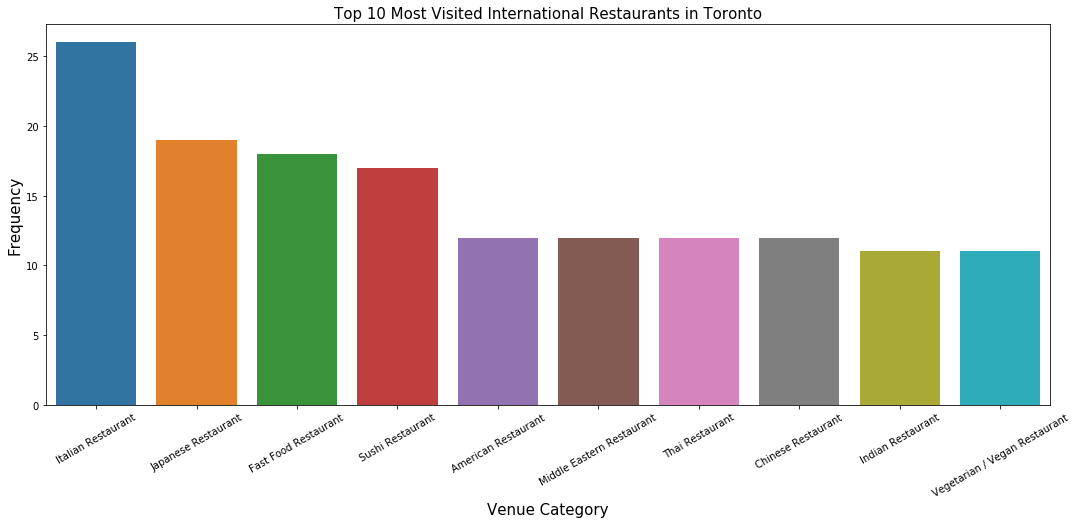

In [24]:
# create a dataframe of top 10 categories
toronto_venues_only_restaurant_int_final_top10 = toronto_venues_only_restaurant_int_final['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
toronto_venues_only_restaurant_int_final_top10=toronto_venues_only_restaurant_int_final_top10.reset_index()

toronto_venues_only_restaurant_int_final_top10.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)

fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue Category", y="Frequency", data=toronto_venues_only_restaurant_int_final_top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('Top 10 Most Visited International Restaurants in Toronto', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

### E. Cluster the Neighborhoods in Toronto Based on Top Venues in Borough

#### 1. Neighborhoods analysis with the international restaurants only

In [25]:
### Let's list the neighborhood with international restaurant without Ethiopian restaurant
toronto_venues_only_restaurant_int_final=toronto_venues_only_restaurant_int[toronto_venues_only_restaurant['Venue Category']!=('Ethiopian Restaurant')].reset_index(drop=True)

### And let's examine the new dataframe size.
toronto_venues_only_restaurant_int_final.index = np.arange(1, len(toronto_venues_only_restaurant_int_final)+1)
print ("Shape of the Data-Frame with Venue Category only International Restaurant: ", toronto_venues_only_restaurant_int_final.shape)
toronto_venues_only_restaurant_int_final.head(10)

Shape of the Data-Frame with Venue Category only International Restaurant:  (249, 7)


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


Neighborhood  Neighborhood Latitude  \
1                                      Malvern, Rouge              43.806686   
2                   Guildwood, Morningside, West Hill              43.763573   
3                                              Woburn              43.770992   
4                                              Woburn              43.770992   
5                                           Cedarbrae              43.773136   
6                                           Cedarbrae              43.773136   
7                                           Cedarbrae              43.773136   
8         Kennedy Park, Ionview, East Birchmount Park              43.727929   
9     Cliffside, Cliffcrest, Scarborough Village West              43.716316   
10  Dorset Park, Wexford Heights, Scarborough Town...              43.757410   

    Neighborhood Longitude                     Venue  Venue Latitude  \
1               -79.194353                   Wendy’s       43.807448   
2               -79.188711          Big Bite Burrito       43.766299   
3               -79.216917        Korean Grill House       43.770812   
4               -79.216917   Al-Hamd Biryani & Pizza       43.767585   
5               -79.239476       Federick Restaurant       43.774697   
6               -79.239476  Drupati's Roti & Doubles       43.775222   
7               -79.239476               Thai One On       43.774468   
8               -79.262029                Hakka No.1       43.727688   
9               -79.239476            Vincent's Spot       43.717002   
10              -79.273304                   Kairali       43.754915   

    Venue Longitude        Venue Category  
1        -79.199056  Fast Food Restaurant  
2        -79.190720    Mexican Restaurant  
3        -79.214502     Korean Restaurant  
4        -79.219570     Indian Restaurant  
5        -79.241142      Hakka Restaurant  
6        -79.241678  Caribbean Restaurant  
7        -79.241268       Thai Restaurant  
8        -79.266057    Chinese Restaurant  
9        -79.242353   American Restaurant  
10       -79.276945     Indian Restaurant

##### Use onehot to conver categorical data

In [27]:
toronto_onehot = pd.get_dummies(toronto_venues_only_restaurant_int_final[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues_only_restaurant_int_final['Neighborhood'] 

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

Neighborhood  American Restaurant  Asian Restaurant  \
1                     Malvern, Rouge                    0                 0   
2  Guildwood, Morningside, West Hill                    0                 0   
3                             Woburn                    0                 0   
4                             Woburn                    0                 0   
5                          Cedarbrae                    0                 0   

   Belgian Restaurant  Cajun / Creole Restaurant  Caribbean Restaurant  \
1                   0                          0                     0   
2                   0                          0                     0   
3                   0                          0                     0   
4                   0                          0                     0   
5                   0                          0                     0   

   Chinese Restaurant  Colombian Restaurant  Comfort Food Restaurant  \
1                   0                     0                        0   
2                   0                     0                        0   
3                   0                     0                        0   
4                   0                     0                        0   
5                   0                     0                        0   

   Cuban Restaurant  ...  New American Restaurant  Portuguese Restaurant  \
1                 0  ...                        0                      0   
2                 0  ...                        0                      0   
3                 0  ...                        0                      0   
4                 0  ...                        0                      0   
5                 0  ...                        0                      0   

   Ramen Restaurant  Seafood Restaurant  Sushi Restaurant  \
1                 0                   0                 0   
2                 0                   0                 0   
3                 0                   0                 0   
4                 0                   0                 0   
5                 0                   0                 0   

   Taiwanese Restaurant  Thai Restaurant  Theme Restaurant  \
1                     0                0                 0   
2                     0                0                 0   
3                     0                0                 0   
4                     0                0                 0   
5                     0                0                 0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  
1                              0                      0  
2                              0                      0  
3                              0                      0  
4                              0                      0  
5                              0                      0  

[5 rows x 40 columns]

In [28]:
toronto_onehot.shape

(249, 40)

In [29]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

Neighborhood  American Restaurant  \
0                                           Agincourt             0.000000   
1     Bathurst Manor, Wilson Heights, Downsview North             0.000000   
2                                     Bayview Village             0.000000   
3                   Bedford Park, Lawrence Manor East             0.125000   
4                                         Berczy Park             0.000000   
5        Brockton, Parkdale Village, Exhibition Place             0.000000   
6   Business reply mail Processing Centre, South C...             0.000000   
7               Canada Post Gateway Processing Centre             0.333333   
8                                           Cedarbrae             0.000000   
9                                  Central Bay Street             0.000000   
10                                           Christie             0.000000   
11                               Church and Wellesley             0.000000   
12            Clarks Corners, Tam O'Shanter, Sullivan             0.000000   
13    Cliffside, Cliffcrest, Scarborough Village West             1.000000   
14                     Commerce Court, Victoria Hotel             0.200000   
15                                         Davisville             0.000000   
16   Del Ray, Mount Dennis, Keelsdale and Silverthorn             0.000000   
17                                          Don Mills             0.000000   
18  Dorset Park, Wexford Heights, Scarborough Town...             0.000000   
19                       Dufferin, Dovercourt Village             0.000000   
20                       Fairview, Henry Farm, Oriole             0.333333   
21             First Canadian Place, Underground city             0.200000   
22    Forest Hill North & West, Forest Hill Road Park             0.000000   
23                           Garden District, Ryerson             0.000000   
24                                          Glencairn             0.000000   
25                  Guildwood, Morningside, West Hill             0.000000   
26  Harbourfront East, Union Station, Toronto Islands             0.000000   
27                      High Park, The Junction South             0.000000   
28                                  Hillcrest Village             0.000000   
29                     India Bazaar, The Beaches West             0.000000   
..                                                ...                  ...   
33                                            Leaside             0.000000   
34                           Little Portugal, Trinity             0.000000   
35                                     Malvern, Rouge             0.000000   
36  Mimico NW, The Queensway West, South of Bloor,...             0.000000   
37       New Toronto, Mimico South, Humber Bay Shores             0.333333   
38                 North Toronto West,  Lawrence Park             0.000000   
39                    Northwood Park, York University             0.000000   
40                             Parkdale, Roncesvalles             0.000000   
41                    Parkview Hill, Woodbine Gardens             0.000000   
42        Queen's Park, Ontario Provincial Government             0.000000   
43                          Regent Park, Harbourfront             0.000000   
44                           Richmond, Adelaide, King             0.125000   
45                                 Runnymede, Swansea             0.000000   
46  South Steeles, Silverstone, Humbergate, Jamest...             0.000000   
47                                     St. James Town             0.142857   
48                        St. James Town, Cabbagetown             0.000000   
49                      Steeles West, L'Amoreaux West             0.000000   
50                                     Stn A PO Boxes             0.000000   
51                                    Studio District             0.142857   
52  Summerhill West, Rathnelly, South Hill, Forest...          

#### 2. Confirm the new size

In [30]:
toronto_grouped.shape

(63, 40)

#### 3. Print each neighborhood along with the top 10 most common internal restaurant

In [31]:
num_top_venues = 10
for neigh in toronto_grouped['Neighborhood']:
    print("----"+neigh+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == neigh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                        venue  freq
0   Latin American Restaurant   1.0
1         American Restaurant   0.0
2     New American Restaurant   0.0
3           Korean Restaurant   0.0
4            Malay Restaurant   0.0
5    Mediterranean Restaurant   0.0
6          Mexican Restaurant   0.0
7   Middle Eastern Restaurant   0.0
8  Modern European Restaurant   0.0
9       Portuguese Restaurant   0.0


----Bathurst Manor, Wilson Heights, Downsview North----
                        venue  freq
0            Sushi Restaurant   0.5
1   Middle Eastern Restaurant   0.5
2         American Restaurant   0.0
3     New American Restaurant   0.0
4           Korean Restaurant   0.0
5   Latin American Restaurant   0.0
6            Malay Restaurant   0.0
7    Mediterranean Restaurant   0.0
8          Mexican Restaurant   0.0
9  Modern European Restaurant   0.0


----Bayview Village----
                        venue  freq
0         Japanese Restaurant   0.5
1          Chinese Restaurant   0.

#### 4. Put that into a pandas dataframe

##### First, let's write a function to sort the venues in descending order

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

##### Now create the new dataframe and display the top 5 venues for each neighborhood.

In [34]:
import numpy as np
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.shape
neighborhoods_venues_sorted

Neighborhood  \
0                                           Agincourt   
1     Bathurst Manor, Wilson Heights, Downsview North   
2                                     Bayview Village   
3                   Bedford Park, Lawrence Manor East   
4                                         Berczy Park   
5        Brockton, Parkdale Village, Exhibition Place   
6   Business reply mail Processing Centre, South C...   
7               Canada Post Gateway Processing Centre   
8                                           Cedarbrae   
9                                  Central Bay Street   
10                                           Christie   
11                               Church and Wellesley   
12            Clarks Corners, Tam O'Shanter, Sullivan   
13    Cliffside, Cliffcrest, Scarborough Village West   
14                     Commerce Court, Victoria Hotel   
15                                         Davisville   
16   Del Ray, Mount Dennis, Keelsdale and Silverthorn   
17                                          Don Mills   
18  Dorset Park, Wexford Heights, Scarborough Town...   
19                       Dufferin, Dovercourt Village   
20                       Fairview, Henry Farm, Oriole   
21             First Canadian Place, Underground city   
22    Forest Hill North & West, Forest Hill Road Park   
23                           Garden District, Ryerson   
24                                          Glencairn   
25                  Guildwood, Morningside, West Hill   
26  Harbourfront East, Union Station, Toronto Islands   
27                      High Park, The Junction South   
28                                  Hillcrest Village   
29                     India Bazaar, The Beaches West   
..                                                ...   
33                                            Leaside   
34                           Little Portugal, Trinity   
35                                     Malvern, Rouge   
36  Mimico NW, The Queensway West, South of Bloor,...   
37       New Toronto, Mimico South, Humber Bay Shores   
38                 North Toronto West,  Lawrence Park   
39                    Northwood Park, York University   
40                             Parkdale, Roncesvalles   
41                    Parkview Hill, Woodbine Gardens   
42        Queen's Park, Ontario Provincial Government   
43                          Regent Park, Harbourfront   
44                           Richmond, Adelaide, King   
45                                 Runnymede, Swansea   
46  South Steeles, Silverstone, Humbergate, Jamest...   
47                                     St. James Town   
48                        St. James Town, Cabbagetown   
49                      Steeles West, L'Amoreaux West   
50                                     Stn A PO Boxes   
51                                    Studio District   
52  Summerhill West, Rathnelly, South Hill, Forest...   
53                The Annex, North Midtown, Yorkville   
54                       The Danforth West, Riverdale   
55                                   Thorncliffe Park   
56           Toronto Dominion Centre, Design Exchange   
57                     University of Toronto, Harbord   
58                                   Victoria Village   
59                                          Westmount   
60                                  Wexford, Maryvale   
61                        Willowdale, Willowdale East   
62                                             Woburn   

          1st Most Common Venue          2nd Most Common Venue  \
0     Latin American Restaurant          Vietnamese Restaurant   
1     Middle Eastern Restaurant               Sushi Restaurant   
2           Japanese Restaurant             Chinese Restaurant   
3            Italian Restaurant            American Restaurant   
4       Comfort Food Restaurant  Vegetarian / Vegan Restaurant   
5            Italian Restaurant          Vietnamese Restaurant   
6          Fast Food Restaurant          Vie

#### 5.  Neighborhoods Clustering

In [36]:
from sklearn.cluster import KMeans
import sklearn.cluster.k_means_
km = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=1, verbose=True)

##### Run k-means to cluster the neighborhood into 5 clusters.
K-means clustering algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster while keeping the centroids as small as possible. It is one of the simplest and popular unsupervised machine learning algorithms

In [37]:
kclusters =5
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(toronto_grouped_clustering)
print(kmeans.labels_[0:10])
print(len(kmeans.labels_))

[2 4 1 1 2 3 0 2 1 2]
63


##### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [38]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = df_toronto
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood').dropna()

toronto_merged.head() # check the last columns!

PostalCode      Borough                                 Neighborhood  \
0        M1B  Scarborough                               Malvern, Rouge   
2        M1E  Scarborough            Guildwood, Morningside, West Hill   
3        M1G  Scarborough                                       Woburn   
4        M1H  Scarborough                                    Cedarbrae   
6        M1K  Scarborough  Kennedy Park, Ionview, East Birchmount Park   

    Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0  43.806686 -79.194353             0.0  Fast Food Restaurant   
2  43.763573 -79.188711             2.0    Mexican Restaurant   
3  43.770992 -79.216917             1.0     Indian Restaurant   
4  43.773136 -79.239476             1.0      Hakka Restaurant   
6  43.727929 -79.262029             1.0    Chinese Restaurant   

   2nd Most Common Venue  3rd Most Common Venue 4th Most Common Venue  \
0  Vietnamese Restaurant     Dim Sum Restaurant      Greek Restaurant   
2  Vietnamese Restaurant      Indian Restaurant      Greek Restaurant   
3      Korean Restaurant  Vietnamese Restaurant      Greek Restaurant   
4        Thai Restaurant   Caribbean Restaurant    Dim Sum Restaurant   
6  Vietnamese Restaurant     Dim Sum Restaurant      Greek Restaurant   

    5th Most Common Venue   6th Most Common Venue 7th Most Common Venue  \
0  Gluten-free Restaurant       French Restaurant    Falafel Restaurant   
2  Gluten-free Restaurant       French Restaurant  Fast Food Restaurant   
3  Gluten-free Restaurant       French Restaurant  Fast Food Restaurant   
4        Greek Restaurant  Gluten-free Restaurant     French Restaurant   
6  Gluten-free Restaurant       French Restaurant  Fast Food Restaurant   

  8th Most Common Venue        9th Most Common Venue  \
0  Ethiopian Restaurant  Eastern European Restaurant   
2    Falafel Restaurant         Ethiopian Restaurant   
3    Falafel Restaurant         Ethiopian Restaurant   
4  Fast Food Restaurant           Falafel Restaurant   
6    Falafel Restaurant         Ethiopian Restaurant   

        10th Most Common Venue  
0             Cuban Restaurant  
2  Eastern European Restaurant  
3  Eastern European Restaurant  
4         Ethiopian Restaurant  
6  Eastern European Restaurant

#### 6. Finally, let's visualize the resulting clusters

In [39]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'],kmeans.labels_):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, popup=label, color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(map_clusters)
map_clusters

#### 6. Explore the clusters

##### Cluster 1

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
0     Scarborough             0.0  Fast Food Restaurant   
35      East York             0.0  Fast Food Restaurant   
42   East Toronto             0.0  Fast Food Restaurant   
80           York             0.0  Fast Food Restaurant   
87   East Toronto             0.0  Fast Food Restaurant   
92      Etobicoke             0.0  Fast Food Restaurant   
101     Etobicoke             0.0  Fast Food Restaurant   

     2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
0    Vietnamese Restaurant    Dim Sum Restaurant       Greek Restaurant   
35   Vietnamese Restaurant    Dim Sum Restaurant       Greek Restaurant   
42      Italian Restaurant      Sushi Restaurant  Vietnamese Restaurant   
80   Vietnamese Restaurant    Dim Sum Restaurant       Greek Restaurant   
87   Vietnamese Restaurant    Dim Sum Restaurant       Greek Restaurant   
92   Vietnamese Restaurant    Dim Sum Restaurant       Greek Restaurant   
101  Vietnamese Restaurant    Dim Sum Restaurant       Greek Restaurant   

      5th Most Common Venue   6th Most Common Venue 7th Most Common Venue  \
0    Gluten-free Restaurant       French Restaurant    Falafel Restaurant   
35   Gluten-free Restaurant       French Restaurant    Falafel Restaurant   
42       Dim Sum Restaurant  Gluten-free Restaurant     French Restaurant   
80   Gluten-free Restaurant       French Restaurant    Falafel Restaurant   
87   Gluten-free Restaurant       French Restaurant    Falafel Restaurant   
92   Gluten-free Restaurant       French Restaurant    Falafel Restaurant   
101  Gluten-free Restaurant       French Restaurant    Falafel Restaurant   

    8th Most Common Venue        9th Most Common Venue  \
0    Ethiopian Restaurant  Eastern European Restaurant   
35   Ethiopian Restaurant  Eastern European Restaurant   
42     Falafel Restaurant         Ethiopian Restaurant   
80   Ethiopian Restaurant  Eastern European Restaurant   
87   Ethiopian Restaurant  Eastern European Restaurant   
92   Ethiopian Restaurant  Eastern European Restaurant   
101  Ethiopian Restaurant  Eastern European Restaurant   

          10th Most Common Venue  
0               Cuban Restaurant  
35              Cuban Restaurant  
42   Eastern European Restaurant  
80              Cuban Restaurant  
87              Cuban Restaurant  
92              Cuban Restaurant  
101             Cuban Restaurant

##### Cluster 2

In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels        1st Most Common Venue  \
3        Scarborough             1.0            Indian Restaurant   
4        Scarborough             1.0             Hakka Restaurant   
6        Scarborough             1.0           Chinese Restaurant   
10       Scarborough             1.0            Indian Restaurant   
13       Scarborough             1.0           Italian Restaurant   
15       Scarborough             1.0           Chinese Restaurant   
19        North York             1.0          Japanese Restaurant   
26        North York             1.0             Asian Restaurant   
27        North York             1.0             Asian Restaurant   
29        North York             1.0        Vietnamese Restaurant   
39         East York             1.0            Indian Restaurant   
41      East Toronto             1.0             Greek Restaurant   
46   Central Toronto             1.0           Italian Restaurant   
47   Central Toronto             1.0             Sushi Restaurant   
51  Downtown Toronto             1.0           Italian Restaurant   
52  Downtown Toronto             1.0            Indian Restaurant   
59  Downtown Toronto             1.0           Italian Restaurant   
62        North York             1.0           Italian Restaurant   
66  Downtown Toronto             1.0           Italian Restaurant   
82      West Toronto             1.0           Mexican Restaurant   
83      West Toronto             1.0  Eastern European Restaurant   
99         Etobicoke             1.0    Middle Eastern Restaurant   

    2nd Most Common Venue      3rd Most Common Venue  \
3       Korean Restaurant      Vietnamese Restaurant   
4         Thai Restaurant       Caribbean Restaurant   
6   Vietnamese Restaurant         Dim Sum Restaurant   
10  Vietnamese Restaurant         Chinese Restaurant   
13        Thai Restaurant       Fast Food Restaurant   
15   Fast Food Restaurant          Indian Restaurant   
19     Chinese Restaurant      Vietnamese Restaurant   
26    Japanese Restaurant         Dim Sum Restaurant   
27    Japanese Restaurant         Dim Sum Restaurant   
29   Caribbean Restaurant         Dim Sum Restaurant   
39   Fast Food Restaurant  Middle Eastern Restaurant   
41     Italian Restaurant       Caribbean Restaurant   
46   Fast Food Restaurant         Chinese Restaurant   
47     Italian Restaurant          Indian Restaurant   
51      Indian Restaurant            Thai Restaurant   
52     Mexican Restaurant           Theme Restaurant   
59    Japanese Restaurant         Chinese Restaurant   
62    American Restaurant           Sushi Restaurant   
66    Japanese Restaurant           Sushi Restaurant   
82        Thai Restaurant         Italian Restaurant   
83     Italian Restaurant           Cuban Restaurant   
99     Chinese Restaurant      Vietnamese Restaurant   

          4th Most Common Venue        5th Most Common Venue  \
3              Greek Restaurant       Gluten-free Restaurant   
4            Dim Sum Restaurant             Greek Restaurant   
6              Greek Restaurant       Gluten-free Restaurant   
10  Eastern European Restaurant             Greek Restaurant   
13           Chinese Restaurant        Vietnamese Restaurant   
15        Vietnamese Restaurant  Eastern European Restaurant   
19  Eastern European Restaurant             Greek Restaurant   
26           Italian Restaurant         Caribbean Restaurant   
27           Italian Restaurant         Caribbean Restaurant   
29             Greek Restaurant       Gluten-free Restaurant   
39        Vietnamese Restaurant             Greek Restaurant   
41        Vietnamese Restaurant  Eastern European Restaurant   
46           Mexican Restaurant        Vietnamese Restaurant   
47              Thai Restaurant           Seafood Restaurant   
51         Taiwanese Restaurant         Caribbean Restaurant   
52             Ramen Restaurant         Ethiopian Restaurant   
59      New American Restaurant        Vietnames

##### Cluster 3

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels      1st Most Common Venue  \
2        Scarborough             2.0         Mexican Restaurant   
8        Scarborough             2.0        American Restaurant   
11       Scarborough             2.0  Middle Eastern Restaurant   
12       Scarborough             2.0  Latin American Restaurant   
17        North York             2.0   Mediterranean Restaurant   
18        North York             2.0        American Restaurant   
22        North York             2.0           Ramen Restaurant   
34        North York             2.0      Portuguese Restaurant   
43      East Toronto             2.0        American Restaurant   
49   Central Toronto             2.0      Vietnamese Restaurant   
53  Downtown Toronto             2.0          French Restaurant   
54  Downtown Toronto             2.0         Mexican Restaurant   
55  Downtown Toronto             2.0        American Restaurant   
56  Downtown Toronto             2.0    Comfort Food Restaurant   
57  Downtown Toronto             2.0  Middle Eastern Restaurant   
58  Downtown Toronto             2.0        American Restaurant   
60  Downtown Toronto             2.0        Japanese Restaurant   
61  Downtown Toronto             2.0        Japanese Restaurant   
65   Central Toronto             2.0          Indian Restaurant   
67  Downtown Toronto             2.0      Vietnamese Restaurant   
69  Downtown Toronto             2.0         Seafood Restaurant   
70  Downtown Toronto             2.0         Seafood Restaurant   
71        North York             2.0      Vietnamese Restaurant   
72        North York             2.0           Asian Restaurant   
76      West Toronto             2.0  Middle Eastern Restaurant   
77      West Toronto             2.0           Asian Restaurant   
84      West Toronto             2.0         Italian Restaurant   
86       Mississauga             2.0        American Restaurant   
88         Etobicoke             2.0        American Restaurant   

            2nd Most Common Venue          3rd Most Common Venue  \
2           Vietnamese Restaurant              Indian Restaurant   
8              Dim Sum Restaurant               Greek Restaurant   
11          Vietnamese Restaurant              Indian Restaurant   
12          Vietnamese Restaurant              Indian Restaurant   
17          Vietnamese Restaurant              Indian Restaurant   
18            Japanese Restaurant           Fast Food Restaurant   
22          Vietnamese Restaurant           Fast Food Restaurant   
34          Vietnamese Restaurant             Dim Sum Restaurant   
43             Seafood Restaurant             Italian Restaurant   
49               Sushi Restaurant            American Restaurant   
53          Vietnamese Restaurant             Dim Sum Restaurant   
54                Thai Restaurant           Fast Food Restaurant   
55        New American Restaurant  Vegetarian / Vegan Restaurant   
56  Vegetarian / Vegan Restaurant                Thai Restaurant   
57  Vegetarian / Vegan Restaurant               Sushi Restaurant   
58               Asian Restaurant  Vegetarian / Vegan Restaurant   
60            American Restaurant              Indian Restaurant   
61            American Restaurant         Gluten-free Restaurant   
65      Middle Eastern Restaurant  Vegetarian / Vegan Restaurant   
67             Mexican Restaurant  Vegetarian / Vegan Restaurant   
69        Comfort Food Restaurant  Vegetarian / Vegan Restaurant   
70            American Restaurant         Gluten-free Restaurant   
71             Dim Sum Restaurant               Greek Restaurant   
72            Japanese Restaurant               Sushi Restaurant   
76          Portuguese Restaurant          Vietnamese Restaurant   
77          Vietnamese Restaurant               Cuban Restaurant   
84               Sushi Restaurant  Vegetarian / Vegan Restaurant   
86       Mediterranean Restaurant      Middle Eastern Restaurant   
88           Fast Food Restaur

##### Cluster 4

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
75  Downtown Toronto             3.0    Italian Restaurant   
78      West Toronto             3.0    Italian Restaurant   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
75  Vietnamese Restaurant     Indian Restaurant      Greek Restaurant   
78  Vietnamese Restaurant     Indian Restaurant      Greek Restaurant   

     5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
75  Gluten-free Restaurant     French Restaurant  Fast Food Restaurant   
78  Gluten-free Restaurant     French Restaurant  Fast Food Restaurant   

   8th Most Common Venue 9th Most Common Venue       10th Most Common Venue  
75    Falafel Restaurant  Ethiopian Restaurant  Eastern European Restaurant  
78    Falafel Restaurant  Ethiopian Restaurant  Eastern European Restaurant

##### Cluster 5

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels      1st Most Common Venue  \
28        North York             4.0  Middle Eastern Restaurant   
38         East York             4.0           Sushi Restaurant   
64   Central Toronto             4.0           Sushi Restaurant   
85  Downtown Toronto             4.0           Sushi Restaurant   

    2nd Most Common Venue  3rd Most Common Venue   4th Most Common Venue  \
28       Sushi Restaurant  Vietnamese Restaurant  Gluten-free Restaurant   
38  Vietnamese Restaurant     Dim Sum Restaurant        Greek Restaurant   
64  Vietnamese Restaurant     Dim Sum Restaurant        Greek Restaurant   
85     Italian Restaurant     Mexican Restaurant   Vietnamese Restaurant   

     5th Most Common Venue   6th Most Common Venue 7th Most Common Venue  \
28       French Restaurant    Fast Food Restaurant    Falafel Restaurant   
38  Gluten-free Restaurant       French Restaurant  Fast Food Restaurant   
64  Gluten-free Restaurant       French Restaurant  Fast Food Restaurant   
85      Dim Sum Restaurant  Gluten-free Restaurant     French Restaurant   

   8th Most Common Venue        9th Most Common Venue  \
28  Ethiopian Restaurant  Eastern European Restaurant   
38    Falafel Restaurant         Ethiopian Restaurant   
64    Falafel Restaurant         Ethiopian Restaurant   
85  Fast Food Restaurant           Falafel Restaurant   

         10th Most Common Venue  
28           Dim Sum Restaurant  
38  Eastern European Restaurant  
64  Eastern European Restaurant  
85         Ethiopian Restaurant

### G. Results

K-means clustering show the results into 5 clusters based on the most venues in each borough. As per Toronto census 2016, the top visible-minority groups per Community Council are Toronto & East York, North York,Scarborough, and Etobicoke York, with the later two having the highest percentage of black population 10.8% and 15.7% respectively. The percentage of black population in Toronto and East York is 5.6%, and 5.2% in Etobicoke. Consequently the results of the clustering can be classified as  follows:<br>
-Cluster 1: 4/8 of the boroughs are communities with the highest black percentage <br>
-Cluster 2: 13/22 of the boroughs are communities with the highest black percentage <br>
-Cluster 3: 11/29 of the boroughs are communities with the highest black percentage <br>
-Cluster 4: no neighborhoods with the highest black percentage, but the only Ethiopian Restaurant in Toronto is opened in Toronto Downtown, at at Church and Wellesle, which is little weird<br>
-Cluster 5: 1/4 of boroughs are communities with the highest black percentage <br>
Therefore , the suggested clusters for opening the a few restaurants in Toronto are cluster 1,and 2, and specifically in East York, North York,Scarborough, and Etobicoke York.

### I. Discussions
The selection of cluster 1 and 2 were based on the number of borough having the highest number of black population.  
Cluster 3 could also be considered, since it's the cluster with the highest number of boroughs, but just lag behind in terms of number of communities having the highest percentage of black population. Moreover, 9/29 of the boroughs are Toronto Downtown, where the Ethiopian Restaurants is actually opened. The overall,results could be better if the population and nationalities data per neighborhood were available so that we can spot and target the right neighborhoods with African communities.

### J. Conclusion
There are many ways to conduct this analysis, but I chose the methods I chose the method I selected as it was a straightforward way to narrow down the options, not complicating what is actually simple in many ways such as focusing of international restaurants only. Form this project, it can be concluded that data science and machine learning are great ways predictions or decisions making on such risky projects.Without leveraging data, the project could end up opening the restaurants in the clusters 4, and 5, which are the boroughs with nn or east communities with black population.
I also tried to incorporate the data of Toronto's population categorised per immigrants, immigrants percentage, and neighborhoods in order to improve the research quality, but could not find the right data. However, this is not an end point of this research, but rather a starting point that will guide the next part of the process to spot the right locations for a such a project. The next part will involve domain knowledge of the industry, and perhaps, of the city itself.